### Charged particle in Const. Magnetic Field

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
# constants
m = 1 # mass electron
q = 1 # charge electron

# Initial conditions
v0 = np.array([0, 0.5, 0]) # c=1
x0 = np.array([0, 0, 0])
dt = 0.005 # time step
E = np.array([0, 0, 0]) # electric field
B = np.array([0, 0, 1]) # magnetic field


gamma0 = 1/np.sqrt(1-np.dot(v0, v0)) #v*v is divided by (c^2 = 1)
u0 = v0*gamma0

    
    
N= int(8/dt) # how many loops

### Euler Method

In [3]:
def RHS(u_n):
    gamma = np.sqrt(1+np.dot(u_n, u_n))
    ddt_x = u_n[0]/gamma
    ddt_y = u_n[1]/gamma
    ddt_z = u_n[2]/gamma

    ddt_ux = np.cross(u_n/gamma, B)[0]
    ddt_uy = np.cross(u_n/gamma, B)[1]
    ddt_uz = np.cross(u_n/gamma, B)[2]

    return np.array([ddt_x, ddt_y, ddt_z, ddt_ux, ddt_uy, ddt_uz])

def Euler_Step(x_n, u_n, dt):
    dx, dy, dz, dux, duy, duz = RHS(u_n)
    x_new = x_n[0]+dx*dt
    y_new = x_n[1]+dy*dt
    z_new = x_n[2]+dz*dt

    pos_new = np.array([x_new, y_new, z_new])

    u_new = u_n + np.array([dux, duy, duz])*dt
    return pos_new, u_new

In [4]:
X = np.zeros((N, 3)) 
U = np.zeros((N, 3)) 

X[0] = x0
U[0] = u0

for i in tqdm(np.arange(0, N-1)):
    X[i+1], U[i+1] = Euler_Step(X[i], U[i], dt)


100%|██████████| 1599/1599 [00:00<00:00, 22626.33it/s]


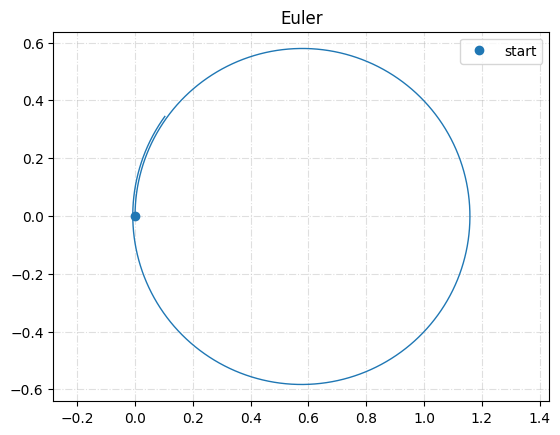

In [5]:
plt.plot(X[:, 0], X[:,1], lw=1)
plt.plot(X[0, 0], X[0, 1], 'o', label='start', c='tab:blue')
plt.legend()    
plt.axis('equal')
plt.title('Euler')
plt.grid(True, ls='-.', alpha=0.4)

### Runge Kutta

In [42]:
def RK4_Step(x_n, u_n, dt):
    k1 = RHS(u_n)
    k2 = RHS(u_n + k1[3:] * dt / 2)
    k3 = RHS(u_n + k2[3:] * dt / 2)
    k4 = RHS(u_n + k3[3:] * dt)

    x_new = x_n + (k1[:3] + 2*k2[:3] + 2*k3[:3] + k4[:3]) * dt / 6
    u_new = u_n + (k1[3:] + 2*k2[3:] + 2*k3[3:] + k4[3:]) * dt / 6


    return x_new, u_new

In [43]:
Xr = np.zeros((N, 3)) 
Ur = np.zeros((N, 3)) 

Xr[0] = x0
Ur[0] = u0
for i in tqdm(np.arange(0, N-1)):
    Xr[i+1], Ur[i+1] = RK4_Step(Xr[i], Ur[i], dt) 

100%|██████████| 1599/1599 [00:00<00:00, 6736.95it/s]


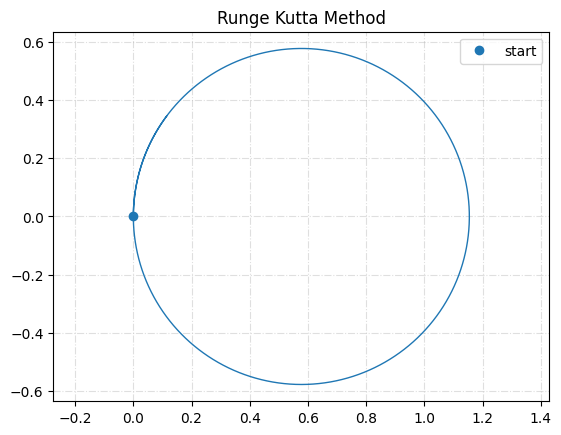

In [9]:
plt.plot(Xr[:, 0], Xr[:,1], lw=1)
plt.plot(Xr[0, 0], Xr[0, 1], 'o', label='start', c='tab:blue')
plt.legend()    
plt.title('Runge Kutta Method')
plt.axis('equal')
plt.grid(True, ls='-.', alpha=0.4)


### Boris Pusher from PS3

In [10]:
def pusher(x, v, u, q, dt, m, E, B, N):
    x_arr = []
    v_arr = []
    u_arr = []
    x_arr.append(x)
    v_arr.append(v)
    u_arr.append(u)
    for i in np.arange(0, N-1):
        u_old = u # set u^n-1
        u_neg = u_old + q*dt/(2*m)*E 
        gamma_neg = np.sqrt(1+np.dot(u_neg, u_neg))

        t = B*q*dt/(2*m*gamma_neg) # not time
        s = 2*t/(1+np.dot(t, t))

        u_pos = u_neg + np.cross((u_neg+np.cross(u_neg, t)), s)
        u_new = u_pos+q*dt/(2*m)*E # u^n+1

        v_arr.append((u_new + u_old)/(2*gamma_neg))
        x_arr.append(x_arr[i-1]+v_arr[i-1]*dt)
        u_arr.append(u_new)

        u = u_new # set u_old for next loop
    return x_arr, v_arr, u_arr

Text(0.5, 1.0, 'Boris')

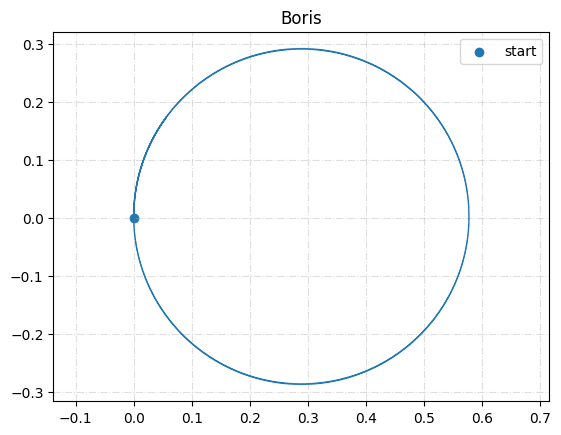

In [11]:
pushed = pusher(x0, v0, u0, q, dt, m, E, B, N)
Xb = np.array(pushed[0])
Ub = np.array(pushed[2])
plt.plot(Xb[:, 0], Xb[:,1], lw=1)
plt.scatter(Xb[0, 0], Xb[0, 1], label='start', c='tab:blue')
plt.legend()
plt.grid(True, ls='-.', alpha=0.4)
plt.axis('equal')
plt.title('Boris')

### Compare Methods

In [48]:
# Creating an array of timeSteps with logarithmic spacing
timeSteps = np.logspace(-4, 1, 10)
# Array to hold deviations for each time step
deviations_eu = np.zeros((len(timeSteps)))
deviations_rk = np.zeros((len(timeSteps)))
deviations_br = np.zeros((len(timeSteps)))

Ke_initial = 0.5*m*np.absolute(np.linalg.norm(Ur[0], axis=0))**2

for k in tqdm(range(len(timeSteps))):

    dt = timeSteps[k]
    n = int(100/dt)

    Xr = np.zeros((N, 3)) 
    Ur = np.zeros((N, 3)) 

    Xr[0] = x0
    Ur[0] = u0
    for i in (np.arange(0, N-1)):
        Xr[i+1], Ur[i+1] = RK4_Step(Xr[i], Ur[i], dt)

    Ke_final_rk = 0.5*m*np.absolute(np.linalg.norm(Ur[-1], axis=0))**2
    energyDeviation = np.abs(Ke_final_rk - Ke_initial)/Ke_initial*100
    deviations_rk[k] = energyDeviation
    X = np.zeros((N, 3)) 
    U = np.zeros((N, 3)) 

    X[0] = x0
    U[0] = u0


    for i in (np.arange(0, N-1)):
        X[i+1], U[i+1] = Euler_Step(U[i], X[i], dt)

    Ke_final_eu = 0.5*m*np.absolute(np.linalg.norm(U[-1], axis=0))**2
    energyDeviation = np.abs(Ke_final_eu - Ke_initial)/Ke_initial*100
    deviations_eu[k] = energyDeviation

    pushed = pusher(x0, v0, u0, q, dt, m, E, B, N)
    Ke_final_br = 0.5*m*np.abs(np.sum(pushed[2][-1]**2))
    energyDeviation = np.abs(Ke_final_br - Ke_initial)/Ke_initial*100
    deviations_br[k] = energyDeviation


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


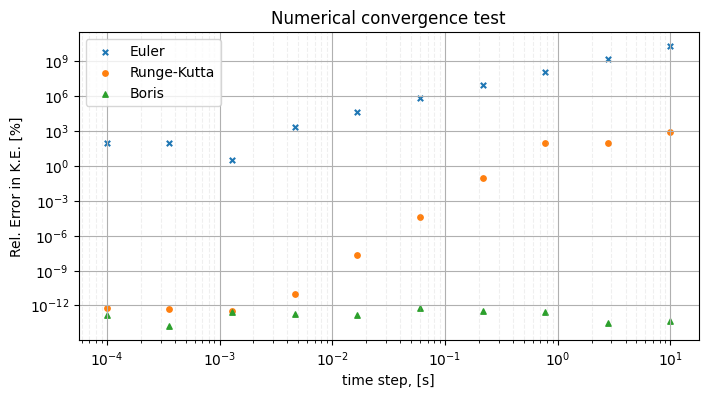

In [49]:
plt.figure(figsize=(8, 4))
plt.scatter(timeSteps, deviations_eu, s=15, marker='x', label='Euler')
plt.scatter(timeSteps, deviations_rk, s=15, marker='o', label='Runge-Kutta')
plt.scatter(timeSteps, deviations_br, s=15, marker='^', label='Boris')
#plt.ylim([1e-20, 1e4])
plt.xlabel('time step, [s]')
plt.ylabel('Rel. Error in K.E. [%]')
plt.grid(True, which='major', ls='-')
plt.grid(True, which='minor', ls='--', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
#plt.gca().invert_xaxis()
plt.title('Numerical convergence test')
plt.legend()
plt.show()

For some reason that I cannot figure out, my Boris pusher is apparently doing very well. This is not real, however I have been unable to locate what is going on. According to the provided literature, Euler should perform the worst, followed by Boris, and RK4 should perform the best.